In [ ]:
%matplotlib inline
!pip install si_prefix
!pip install sphinx
!pip install pykeops[full] > install.log
import pykeops

     |████████████████████████████████| 71kB 8.6MB/s 
  Created wheel for si-prefix: filename=si_prefix-1.2.2-cp36-none-any.whl size=5876 sha256=f9ba19e3274b616912ab594a03d23cc5fb58633f643f83c1712ebedec551a408
  Stored in directory: /root/.cache/pip/wheels/57/d5/5b/3441f65c8ff1a4a01b196a82d91b8bcf4e1ff5409c9ef09d55
Successfully built si-prefix
ERROR: breathe 4.27.0 has requirement Sphinx<3.6,>=3.0, but you'll have sphinx 1.8.5 which is incompatible.



# K-Nearest Neighbours search (WIP)

Let's compare the performances of PyTorch, JAX, FAISS and KeOps fpr 
K-NN queries on random samples and standard datasets.

<div class="alert alert-info"><h4>Note</h4><p>In this demo, we use exact **bruteforce** computations 
    (tensorized for PyTorch and online for KeOps), without leveraging any multiscale
    or low-rank (Nystroem/multipole) decomposition of the Kernel matrix.
    First support for these approximation schemes is scheduled for
    May-June 2021.</p></div>

 


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/keops

/content/drive/My Drive/keops


In [ ]:
!ls /content/drive/My\ Drive/keops/*.py

'/content/drive/My Drive/keops/benchmark_utils.py'
'/content/drive/My Drive/keops/dataset_utils.py'
'/content/drive/My Drive/keops/ivf_functional.py'


## Setup



In [ ]:
import sys
sys.path.append('/content/drive/My Drive/keops')

In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from functools import partial

from benchmark_utils import (
    flatten,
    random_normal,
    full_benchmark,
    timer,
    tensor,
    int_tensor,
    jax_tensor,
)
from dataset_utils import generate_samples

use_cuda = torch.cuda.is_available()

Benchmark specifications:




In [ ]:
# Values of K that we'll loop upon:
#Ks = [1, 25, 100]
Ks = [1, 2, 5, 10, 20, 50, 100]

## Simple bruteforce implementations

Define a simple Gaussian RBF product, using a **tensorized** implementation.
Note that expanding the squared norm $\|x-y\|^2$ as a sum
$\|x\|^2 - 2 \langle x, y \rangle + \|y\|^2$ allows us
to leverage the fast matrix-matrix product of the BLAS/cuBLAS
libraries.


PyTorch bruteforce:




In [ ]:
"""
def KNN_KeOps(K, metric="euclidean", **kwargs):
    def fit(x_train):
        # Setup the K-NN estimator:
        x_train = tensor(x_train)
        start = timer()

        # N.B.: The "training" time here should be negligible.
        elapsed = timer() - start

        def f(x_test):
            x_test = tensor(x_test)
            start = timer()

            # Actual K-NN query:

            elapsed = timer() - start

            indices = indices.cpu().numpy()
            return indices, elapsed

        return f, elapsed

    return fit
"""


def KNN_torch(K, metric="euclidean", **kwargs):
    def fit(x_train):
        # Setup the K-NN estimator:
        x_train = tensor(x_train)
        start = timer()
        # The "training" time here should be negligible:
        x_train_norm = (x_train ** 2).sum(-1)
        elapsed = timer() - start

        def f(x_test):
            x_test = tensor(x_test)
            start = timer()

            # Actual K-NN query:
            if metric == "euclidean":
                x_test_norm = (x_test ** 2).sum(-1)
                diss = (
                    x_test_norm.view(-1, 1)
                    + x_train_norm.view(1, -1)
                    - 2 * x_test @ x_train.t()
                )

            elif metric == "manhattan":
                diss = (x_test[:, None, :] - x_train[None, :, :]).abs().sum(dim=2)

            elif metric == "angular":
                diss = -x_test @ x_train.t()

            elif metric == "hyperbolic":
                x_test_norm = (x_test ** 2).sum(-1)
                diss = (
                    x_test_norm.view(-1, 1)
                    + x_train_norm.view(1, -1)
                    - 2 * x_test @ x_train.t()
                )
                diss /= x_test[:, 0].view(-1, 1) * x_train[:, 0].view(1, -1)

            out = diss.topk(K, dim=1, largest=False)

            elapsed = timer() - start
            indices = out.indices.cpu().numpy()
            return indices, elapsed

        return f, elapsed

    return fit

PyTorch bruteforce, with small batches to avoid memory overflows:



In [ ]:
def KNN_torch_batch_loop(K, metric="euclidean", **kwargs):
    def fit(x_train):
        # Setup the K-NN estimator:
        x_train = tensor(x_train)
        Ntrain, D = x_train.shape
        start = timer()
        # The "training" time here should be negligible:
        x_train_norm = (x_train ** 2).sum(-1)
        elapsed = timer() - start

        def f(x_test):
            x_test = tensor(x_test)

            # Estimate the largest reasonable batch size:
            Ntest = x_test.shape[0]
            #  torch.cuda.get_device_properties(deviceId).total_memory
            av_mem = int(5e8)
            Ntest_loop = min(max(1, av_mem // (4 * D * Ntrain)), Ntest)
            Nloop = (Ntest - 1) // Ntest_loop + 1
            # print(f"{Ntest} queries, split in {Nloop} batches of {Ntest_loop} queries each.")
            out = int_tensor(Ntest, K)

            start = timer()
            # Actual K-NN query:
            for k in range(Nloop):
                x_test_k = x_test[Ntest_loop * k : Ntest_loop * (k + 1), :]
                if metric == "euclidean":
                    x_test_norm = (x_test_k ** 2).sum(-1)
                    diss = (
                        x_test_norm.view(-1, 1)
                        + x_train_norm.view(1, -1)
                        - 2 * x_test_k @ x_train.t()
                    )

                elif metric == "manhattan":
                    diss = (x_test_k[:, None, :] - x_train[None, :, :]).abs().sum(dim=2)

                elif metric == "angular":
                    diss = -x_test_k @ x_train.t()

                elif metric == "hyperbolic":
                    x_test_norm = (x_test_k ** 2).sum(-1)
                    diss = (
                        x_test_norm.view(-1, 1)
                        + x_train_norm.view(1, -1)
                        - 2 * x_test_k @ x_train.t()
                    )
                    diss /= x_test_k[:, 0].view(-1, 1) * x_train[:, 0].view(1, -1)

                out[Ntest_loop * k : Ntest_loop * (k + 1), :] = diss.topk(
                    K, dim=1, largest=False
                ).indices
                del diss
            # torch.cuda.empty_cache()

            elapsed = timer() - start
            indices = out.cpu().numpy()
            return indices, elapsed

        return f, elapsed

    return fit

Distance matrices with JAX:



In [ ]:
from functools import partial
import jax
import jax.numpy as jnp


@partial(jax.jit, static_argnums=(2, 3))
def knn_jax_fun(x_train, x_test, K, metric):
    if metric == "euclidean":
        diss = (
            (x_test ** 2).sum(-1)[:, None]
            + (x_train ** 2).sum(-1)[None, :]
            - 2 * x_test @ x_train.T
        )
    elif metric == "manhattan":
        diss = jax.lax.abs(x_test[:, None, :] - x_train[None, :, :]).sum(-1)
    elif metric == "angular":
        diss = -x_test @ x_train.T
    elif metric == "hyperbolic":
        diss = (
            (x_test ** 2).sum(-1)[:, None]
            + (x_train ** 2).sum(-1)[None, :]
            - 2 * x_test @ x_train.T
        )
        diss = diss / (x_test[:, 0][:, None] * x_train[:, 0][None, :])

    indices = jax.lax.top_k(-diss, K)[1]
    return indices

JAX bruteforce:



In [ ]:
def KNN_JAX(K, metric="euclidean", **kwargs):
    def fit(x_train):

        # Setup the K-NN estimator:
        start = timer(use_torch=False)
        x_train = jax_tensor(x_train)
        elapsed = timer(use_torch=False) - start

        def f(x_test):
            x_test = jax_tensor(x_test)

            # Actual K-NN query:
            start = timer(use_torch=False)
            indices = knn_jax_fun(x_train, x_test, K, metric)
            indices = np.array(indices)
            elapsed = timer(use_torch=False) - start
            return indices, elapsed

        return f, elapsed

    return fit

JAX bruteforce, with small batches to avoid memory overflows:



In [ ]:
def KNN_JAX_batch_loop(K, metric="euclidean", **kwargs):
    def fit(x_train):

        # Setup the K-NN estimator:
        start = timer(use_torch=False)
        x_train = jax_tensor(x_train)
        elapsed = timer(use_torch=False) - start

        def f(x_test):
            x_test = jax_tensor(x_test)

            # Estimate the largest reasonable batch size
            #  torch.cuda.get_device_properties(deviceId).total_memory
            av_mem = int(5e8)
            Ntrain, D = x_train.shape
            Ntest = x_test.shape[0]
            Ntest_loop = min(max(1, av_mem // (4 * D * Ntrain)), Ntest)
            Nloop = (Ntest - 1) // Ntest_loop + 1
            # print(f"{Ntest} queries, split in {Nloop} batches of {Ntest_loop} queries each.")
            indices = np.zeros((Ntest, K), dtype=int)

            start = timer(use_torch=False)
            # Actual K-NN query:
            for k in range(Nloop):
                x_test_k = x_test[Ntest_loop * k : Ntest_loop * (k + 1), :]
                indices[Ntest_loop * k : Ntest_loop * (k + 1), :] = knn_jax_fun(
                    x_train, x_test_k, K, metric
                )
            elapsed = timer(use_torch=False) - start
            return indices, elapsed

        return f, elapsed

    return fit

KeOps bruteforce implementation:




In [ ]:
from pykeops.torch import LazyTensor, Vi, Vj


def KNN_KeOps(K, metric="euclidean", **kwargs):
    def fit(x_train):
        # Setup the K-NN estimator:
        x_train = tensor(x_train)
        start = timer()

        # Encoding as KeOps LazyTensors:
        D = x_train.shape[1]
        X_i = Vi(0, D)
        X_j = Vj(1, D)

        # Symbolic distance matrix:
        if metric == "euclidean":
            D_ij = ((X_i - X_j) ** 2).sum(-1)
        elif metric == "manhattan":
            D_ij = (X_i - X_j).abs().sum(-1)
        elif metric == "angular":
            D_ij = -(X_i | X_j)
        elif metric == "hyperbolic":
            D_ij = ((X_i - X_j) ** 2).sum(-1) / (X_i[0] * X_j[0])

        # K-NN query operator:
        KNN_fun = D_ij.argKmin(K, dim=1)

        # N.B.: The "training" time here should be negligible.
        elapsed = timer() - start

        def f(x_test):
            x_test = tensor(x_test)
            start = timer()

            # Actual K-NN query:
            indices = KNN_fun(x_test, x_train)

            elapsed = timer() - start

            indices = indices.cpu().numpy()
            return indices, elapsed

        return f, elapsed

    return fit

In [ ]:
from ivf_functional import ivf
def ivf_flat(K,  **kwargs):
    
    
    def fit(x_train):
        KNN = ivf(k=K)
        x_train = tensor(x_train)
        # Setup the K-NN estimator:
        start = timer()
        KNN.fit(x_train,clusters=100,a=6)

        elapsed = timer() - start

        def f(x_test):
            x_test = tensor(x_test)
            start = timer()
            indices = KNN.kneighbors(x_test)

            elapsed = timer() - start
            indices = indices.cpu().numpy()
            return indices, elapsed

        return f, elapsed

    return fit

## SciKit-Learn tree-based and bruteforce methods




In [ ]:
from sklearn.neighbors import NearestNeighbors


def KNN_sklearn(K, metric="euclidean", algorithm=None, **kwargs):

    if metric in ["euclidean", "angular"]:
        p = 2
    elif metric == "manhattan":
        p = 1
    else:
        raise NotImplementedError("This distance is not supported.")

    KNN = NearestNeighbors(n_neighbors=K, algorithm=algorithm, p=p, n_jobs=-1)

    def fit(x_train):
        # Setup the K-NN estimator:
        start = timer()
        KNN.fit(x_train)
        elapsed = timer() - start

        def f(x_test):
            start = timer()
            distances, indices = KNN.kneighbors(x_test)
            elapsed = timer() - start

            return indices, elapsed

        return f, elapsed

    return fit


KNN_sklearn_auto = partial(KNN_sklearn, algorithm="auto")
KNN_sklearn_ball_tree = partial(KNN_sklearn, algorithm="ball_tree")
KNN_sklearn_kd_tree = partial(KNN_sklearn, algorithm="kd_tree")
KNN_sklearn_brute = partial(KNN_sklearn, algorithm="brute")

## NumPy vs. PyTorch vs. KeOps (Gpu)



In [ ]:
def run_KNN_benchmark(name=None,**kwargs):

    # Load the dataset and some info:
    dataset = generate_samples(key=name,**kwargs)(1)
    N_train, dimension = dataset["train"].shape
    N_test, _ = dataset["test"].shape
    metric = dataset["metric"]

    # Routines to benchmark:
    routines = [
        (ivf_flat, "IVF-Flat Keops (GPU)", {}),        
        (KNN_sklearn_auto, "sklearn, auto (CPU)", {}),
        (KNN_sklearn_ball_tree, "sklearn, Ball-tree (CPU)", {}),
        (KNN_sklearn_kd_tree, "sklearn, KD-tree (CPU)", {}),
        (KNN_sklearn_brute, "sklearn, bruteforce (CPU)", {}),
        (KNN_torch_batch_loop, "PyTorch (small batches, GPU)", {}),
        (KNN_KeOps, "KeOps (GPU)", {}),
    ]

    # Actual run:
    full_benchmark(
        f"K-NN search on: {N_test:,} queries on a dataset of {N_train:,} points\nin dimension {dimension:,} with a {metric} metric.",
        routines,
        generate_samples(key=name,**kwargs),
        min_time=1e-4,
        max_time=60,
        problem_sizes=Ks,
        xlabel="Number of neighbours K",
    )

## On random samples:

Small dataset in $\mathbb{R}^3$:



Benchmarking : K-NN search on: 100,000 queries on a dataset of 100,000 points
in dimension 2 with a euclidean metric. ===============================
IVF-Flat Keops (GPU) -------------
  1x100 loops of size    1 : train =   1x100x  13.2 ms, test  =   1x100x   4.5 ms, recall =  89%
  1x 10 loops of size    2 : train =   1x 10x  13.0 ms, test  =   1x 10x   5.2 ms, recall =  89%
  1x 10 loops of size    5 : train =   1x 10x  14.7 ms, test  =   1x 10x   6.3 ms, recall =  89%
  1x 10 loops of size   10 : train =   1x 10x  15.0 ms, test  =   1x 10x   7.9 ms, recall =  89%
  1x 10 loops of size   20 : train =   1x 10x  14.2 ms, test  =   1x 10x  10.3 ms, recall =  89%
  1x 10 loops of size   50 : train =   1x 10x  13.3 ms, test  =   1x 10x  25.9 ms, recall =  89%
  1x  1 loops of size  100 : train =   1x  1x  13.0 ms, test  =   1x  1x    1.9 s, recall =  88%
sklearn, auto (CPU) -------------
  1x100 loops of size    1 : train =   1x100x  46.3 ms, test  =   1x100x 203.9 ms, recall = 100%
  1x 

OSError: ignored

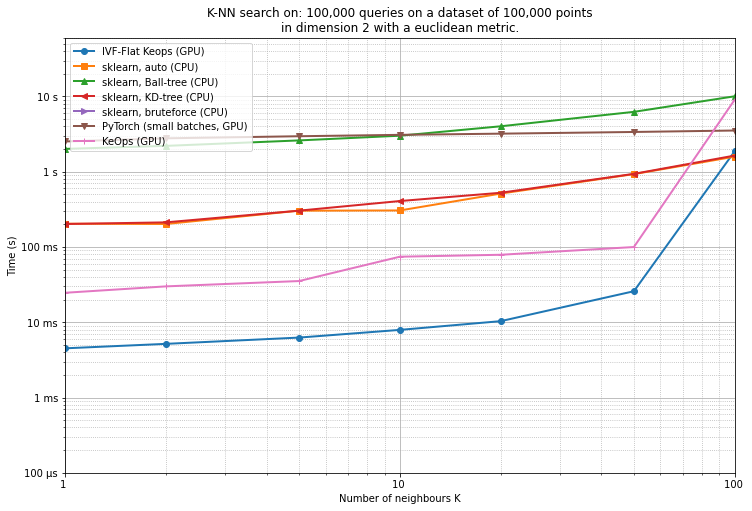

In [ ]:
run_KNN_benchmark(metric='euclidean',ntrain=10**5,ntest=10**5,d=2)

In [ ]:
run_KNN_benchmark(metric='euclidean',ntrain=10**5,ntest=10**5,d=2)

Compiling libKeOpstorch522a65742d in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,2,0) - Var(1,2,1)))),1,0)
       aliases: Var(0,2,0); Var(1,2,1); 
       dtype  : float32
... Done.
Benchmarking : K-NN search on: 100,000 queries on a dataset of 100,000 points
in dimension 2 with a euclidean metric. ===============================
IVF-Flat Keops (GPU) -------------
Compiling libKeOpstorch5fba8c75d5 in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: ArgMin_Reduction(Sum(Square((Var(0,2,0) - Var(1,2,1)))),0)
       aliases: Var(0,2,0); Var(1,2,1); 
       dtype  : float32
... Done.
Compiling libKeOpstorch52de9bd20c in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,2,0) - Var(1,2,1)))),5,0)
       aliases: Var(0,2,0); Var(1,2,1); 
       dtype  : float32
... Done.
  1x100 loops of size    1 : train =   1x100x  17.8 ms, test  =   1x100x   4.8 ms, recall =  89%
Compiling libKeOpstorch6178f28b49 

KeyboardInterrupt: ignored

In [ ]:
run_KNN_benchmark(metric='euclidean',ntrain=10**5,ntest=10**5,d=2)

Benchmarking : K-NN search on: 100,000 queries on a dataset of 100,000 points
in dimension 2 with a euclidean metric. ===============================
IVF-Flat Keops (GPU) -------------
  1x100 loops of size    1 : train =   1x100x  18.4 ms, test  =   1x100x   5.9 ms, recall =  93%
Compiling libKeOpstorch6178f28b49 in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,2,0) - Var(1,2,1)))),2,0)
       aliases: Var(0,2,0); Var(1,2,1); 
       dtype  : float32
... Done.
  1x 10 loops of size    2 : train =   1x 10x  19.6 ms, test  =   1x 10x  10.3 ms, recall =  93%
  1x 10 loops of size    5 : train =   1x 10x  18.3 ms, test  =   1x 10x   8.1 ms, recall =  93%
Compiling libKeOpstorchb73ef06255 in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,2,0) - Var(1,2,1)))),10,0)
       aliases: Var(0,2,0); Var(1,2,1); 
       dtype  : float32
... Done.
  1x 10 loops of size   10 : train =   1x 10x  18.6 ms, test  =  

KeyboardInterrupt: ignored

Large dataset in $\mathbb{R}^3$:



In [ ]:
run_KNN_benchmark("R^D b")
plt.show()